In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import sympy
sympy.init_printing()
import emcee
import corner

In [52]:
data1 = np.loadtxt('proj1data1.txt')

data2 = np.loadtxt('proj1data2.txt')

data3 = np.loadtxt('proj1data3.txt')

data1x = data1[:,0] - 2450000
data2x = data2[:,0] - 2450000
data3x = data3[:,0] - 2450000

data1y = (data1[:,1])
data2y = (data2[:,1])
data3y = (data3[:,1]) 

data1err = data1[:,2]



<ErrorbarContainer object of 3 artists>

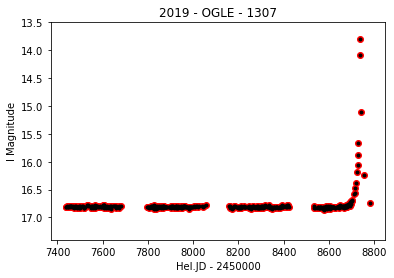

In [53]:
fig,ax = plt.subplots(1)
ax.plot(data1x,data1y,'ro')
ax.invert_yaxis()
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('2019 - OGLE - 1307')
plt.ylim(17.4,13.5)
plt.errorbar(data1x,data1y,data1err, fmt=".",color='black')


In [54]:

def model(par,dat):
    u_0 = par[0]
    t_0 = par[1]
    t_E = par[2]
    m_src = par[3]
    model = 0
    for i in range(len(dat)):
        t = dat[:,0] - 2450000
        
        u = np.sqrt(u_0**2 + (((t-t_0)**2)/t_E**2))
        
        A = (u**2 + 2)/(u* np.sqrt(u**2 + 4))
        
        model = model + (m_src - 2.5*np.log10(A))
    return(model)
    


def lnprob(par,dat):
    return -0.5*model(par,dat)

In [ ]:

ndim = 4
nwalk = 20
nburn = 3000
nmain = 10000

plab = ['u_0','t_0','t_E','m_src']

p0 = np.array([1.0,1.0,1.0,1.0])
pstart = np.array([p0 + 1.0e-4*np.random.normal(size=ndim) for i in range(nwalk)])

sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob, args=(data1,))


print('burn-in run')
pos, prob, state = sampler.run_mcmc(pstart,nburn)


print('main run')
sampler.reset()
res = sampler.run_mcmc(pos,nmain)

samples = sampler.get_chain(flat=True)

f,ax = plt.subplots(ndim,1,figsize=(10,8),sharex=True)

for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_ylabel(plab[idim])
ax[-1].set_xlabel('step')
f.show()

f = corner.corner(samples,show_titles=True, labels=plab)



burn-in run


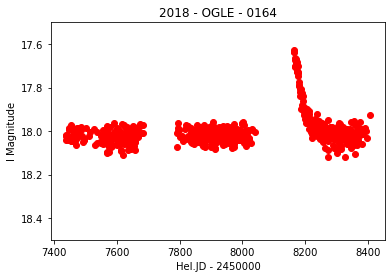

In [41]:
fig,ax = plt.subplots(1)
ax.plot(data2x,data2y,'ro')
ax.invert_yaxis()
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('2018 - OGLE - 0164')
plt.ylim(18.5,17.5)

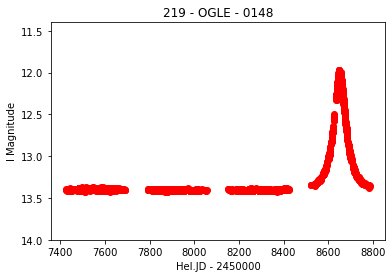

In [40]:
fig,ax = plt.subplots(1)
ax.plot(data3x,data3y,'ro')
ax.invert_yaxis()
plt.xlabel('Hel.JD - 2450000')
plt.ylabel('I Magnitude')
plt.title('219 - OGLE - 0148')
plt.ylim(14,11.4)